# Forecast using Multi Layer DNN 

This notebook covers how to create a multiple layer dense neural net to forecast a time series

- Creation of a windowed dataset 
- Split features and labels 
- Create a model with multiple Dense layers 
- Evaluate performance

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Let's install tensorflow 2.x first :)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    '''
    Plot series of data

    Parameters
    ----------
    time : array of data
    series: array of data to plot in Y axis 
    format: format of basic line properties. Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
    start: from where to start plotting, optional. Default: 0
    end: up to where to plot data, optional. Default: None
    '''
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def trend(time, slope=0):
    '''
    Produce a trend of data.
    Parameters
    ---------- 
    time: time series to plot 
    slope: slope to plot the series. optional, Default: 0
    '''
    return slope * time

In [6]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern by using np.where
    Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
    
    Parameters
    ----------
    season_time: to generate the condition of what to select from 
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    '''
    Repeats the same pattern at each period
    
    Parameters
    ----------
    time: to generate the season over x axis 
    period: how often will repeat
    amplitude: how many phases 
    phase: the position of the point in time
    '''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [8]:
def noise(time, noise_level=1, seed=None):
    '''
    Produce random noise into a time series 

    Parameters
    ----------
    time: series of values on X axis
    noise_level: to be produced, optional. Default: 1
    seed: seed to generate the noise, optional. Default: None 
    '''
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [9]:
# Define initial time series
time = np.arange(4 * 365 + 1, dtype="float32") 

In [10]:
# Define initial values for generation of different time series 
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [11]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

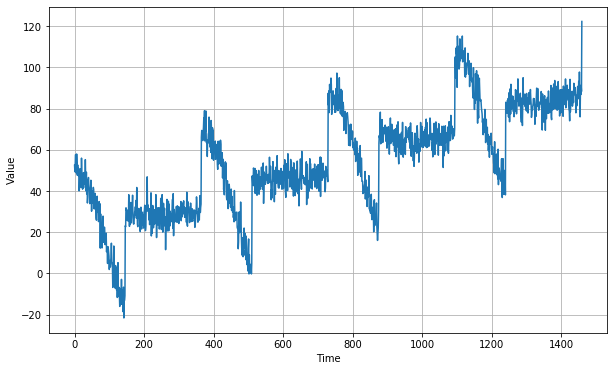

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [13]:
# Split into training and validation
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Creates a windowed dataset and returns only one from the batch 
    
    Parameters
    ----------
    series: time series data to set as dataset
    windows_size: size of the window to be created
    batch_size: size of the batch by window 
    shuffle_buffer: buffer size to take data and shuffle it around
    
    Returns a transformed dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [17]:
# Create a model with 3 Layers layer Created
# Using relu activation and last layer ouput: 1 value
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [18]:
'''
Configure the model with: 
- Loss: mean squared error 
- Optimizer: Stochastic Gradient Descent 
'''
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [19]:
# Train the model for 100 epochs
model.fit(dataset,epochs=100,verbose=0)

In [20]:
# Create a moving average time series with the prediction created by the model
forecast = []
range_values = len(series) - window_size

In [21]:
for time in range(range_values):
    # Add the prediction to the forecast array 
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [22]:
forecast = forecast[split_time-window_size:]

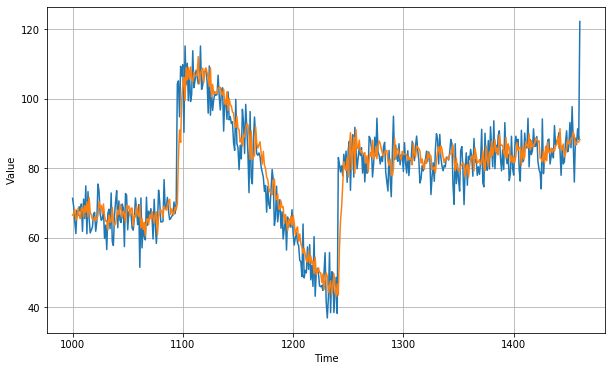

In [23]:
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
# Get the MAE metric
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.020588

# Tuning the learning rate of the optimizer 

Tensorflow offers a way to tune the learning rate on each epoch if need it by using the [Learning Rate Scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)

This is injected on the callbacks namespace and will be set on the callbacks parameter on the fit method related to the model

In [25]:
initial_lr = 1e-8

In [26]:
# Define learning rate scheduler 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: initial_lr * 10**(epoch / 20))

In [27]:
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)

In [28]:
model.compile(loss="mse", optimizer=optimizer)

In [29]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

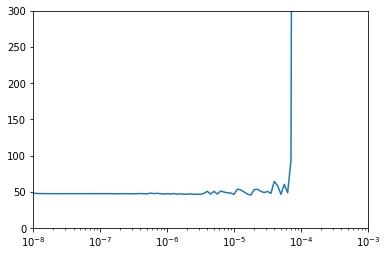

In [30]:
# Plot the learning rates across training 
lrs = initial_lr * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([initial_lr, 1e-3, 0, 300])

In [35]:
history.history["loss"]
lrs[66]

1.995262314968879e-05

## Adjust the learning rate 
After finding the right value for Learning Rate, train again with the new value amnd check the performance metrics

In [ ]:
window_size = 30

In [ ]:
# Create a new windowed dataset
new_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Create a model with 3 layers 
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [ ]:
tuned_learning_rate = 

In [ ]:
# Create the optimizer with the new learning rate after tuning 
optimizer = tf.keras.optimizers.SGD(lr=tuned_learning_rate, momentum=0.9)

In [ ]:
# Configure the model with MSE loss and SGD optimizer
model.compile(loss="mse", optimizer=optimizer)

In [ ]:
# Train the model for 500 epochs
history = model.fit(new_dataset, epochs=500, verbose=0)

In [ ]:
# Plot the losss 
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()